In [ ]:
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yfin
from pandas_datareader import data as pdr
yfin.pdr_override()
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [ ]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(365)

In [ ]:
def get_data(ticker):
  asset = pdr.get_data_yahoo(ticker + '.NS', start = start_date, end = end_date)
  asset.reset_index(inplace = True)
  return asset

In [ ]:
icici = get_data('ICICIBANK')
icici

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-11,925.900024,928.000000,903.500000,906.549988,899.148804,17921457
1,2022-11-14,905.000000,906.549988,891.250000,894.950012,887.643555,12641308
2,2022-11-15,900.549988,913.650024,898.799988,911.700012,904.256775,15176911
3,2022-11-16,912.549988,918.099976,908.099976,913.599976,906.141235,13008311
4,2022-11-17,913.000000,922.299988,910.349976,919.799988,912.290649,12584194
...,...,...,...,...,...,...,...
244,2023-11-06,941.000000,947.750000,937.400024,945.450012,945.450012,10338367
245,2023-11-07,943.599976,950.450012,930.450012,948.099976,948.099976,15704942
246,2023-11-08,948.450012,948.450012,934.099976,935.750000,935.750000,17606074
247,2023-11-09,934.000000,942.349976,933.000000,937.349976,937.349976,9406117


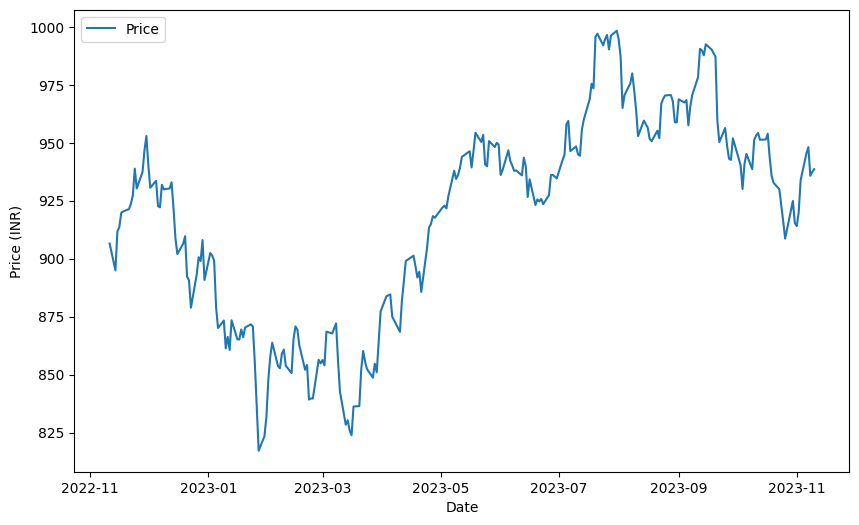

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(icici['Date'], icici['Close'], label = 'Price')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# get all the indicators from scratch one of each type (trend, momentum, volatility and volume)

def macd(asset, period_long = 26, period_short = 12, signal = 9):
  asset['MACDval'] = asset['Close'].ewm(span = period_short).mean() - asset['Close'].ewm(span = period_long).mean()
  asset['MACDsignal'] = asset['MACDval'].ewm(span = signal).mean()
  asset['MACDh'] = asset['MACDval'] - asset['MACDsignal']
  return asset

def rsi(asset, period = 14, ewma = True):
  close_delta = asset['Close'].diff()
  up = close_delta.clip(lower = 0)
  down = -1 * close_delta.clip(upper = 0)
  if ewma == True:
      ma_up = up.ewm(com = period - 1, adjust = True, min_periods = period).mean()
      ma_down = down.ewm(com = period - 1, adjust = True, min_periods = period).mean()
  else:
      ma_up = up.rolling(window = period, adjust = False).mean()
      ma_down = down.rolling(window = period, adjust = False).mean()

  rsi = ma_up / ma_down
  rsi = 100 - (100/(1 + rsi))
  asset['RSI'] = rsi
  return asset

def bollinger_band(asset, period = 20):
  asset['TP_BB'] = (asset['High'] + asset['Low'] + asset['Adj Close'])/3
  asset['BOLM'] = asset['TP_BB'].rolling(window = period).mean()
  stddev = asset['TP_BB'].rolling(window = period).std()
  asset['BOLU'] = asset['BOLM'] + 2 * stddev
  asset['BOLD'] = asset['BOLM'] - 2 * stddev
  return asset

def obv(asset):
  obv = [0]
  for i in range(1, len(asset.Close)):
    if asset.Close[i] > asset.Close[i - 1]:
      obv.append(obv[-1] + asset.Volume[i])
    elif asset.Close[i] < asset.Close[i - 1]:
      obv.append(obv[-1] - asset.Volume[i])
    else:
      obv.append(0)
  asset['OBV'] = obv
  return asset

In [ ]:
macd(icici)
rsi(icici)
obv(icici)
bollinger_band(icici)
icici

,Date,Open,High,Low,Close,Adj Close,Volume,MACDval,MACDsignal,MACDh,RSI,OBV,TP_BB,BOLM,BOLU,BOLD
0,2022-11-11,925.900024,928.000000,903.500000,906.549988,899.148804,17921457,0.000000,0.000000,0.000000,NaN,0,910.216268,NaN,NaN,NaN
1,2022-11-14,905.000000,906.549988,891.250000,894.950012,887.643555,12641308,-0.260256,-0.144587,-0.115669,NaN,-12641308,895.147847,NaN,NaN,NaN
2,2022-11-15,900.549988,913.650024,898.799988,911.700012,904.256775,15176911,0.187799,-0.008363,0.196162,NaN,2535603,905.568929,NaN,NaN,NaN
3,2022-11-16,912.549988,918.099976,908.099976,913.599976,906.141235,13008311,0.455578,0.148799,0.306779,NaN,15543914,910.780396,NaN,NaN,NaN
4,2022-11-17,913.000000,922.299988,910.349976,919.799988,912.290649,12584194,0.838207,0.353882,0.484325,NaN,28128108,914.980204,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-11-06,941.000000,947.750000,937.400024,945.450012,945.450012,10338367,-7.243610,-9.211937,1.968327,54.538385,-85930144,943.533346,934.826665,966.149042,903.504288
245,2023-11-07,943.599976,950.450012,930.450012,948.099976,948.099976,15704942,-5.192429,-8.408036,3.215607,55.776298,-70225202,943.000000,935.027499,966.513178,903.541821
246,2023-11-08,948.450012,948.450012,934.099976,935.750000,935.750000,17606074,-4.511389,-7.628706,3.117318,49.070146,-87831276,939.433329,934.514999,965.322611,903.707388
247,2023-11-09,934.000000,942.349976,933.000000,937.349976,937.349976,9406117,-3.798765,-6.862718,3.063953,49.910386,-78425159,937.566650,933.628333,962.899625,904.357040


In [ ]:
print(f'The dataframe has {icici.shape[0]} rows and {icici.shape[1]} columns')

The dataframe has 249 rows and 16 columns


In [ ]:
icici.isna().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
MACDval        0
MACDsignal     0
MACDh          0
RSI           14
OBV            0
TP_BB          0
BOLM          19
BOLU          19
BOLD          19
dtype: int64

In [ ]:
icici.dropna(inplace = True)
print(f'The dataframe now has {icici.shape[0]} rows and {icici.shape[1]} columns')

The dataframe now has 230 rows and 16 columns


In [ ]:
# target flexible way
pipdiff = 200*1e-4
sltp_ratio = 1.5
def mytarget(asset, barsupfront):
    length = len(asset)
    high = list(asset['High'])
    low = list(asset['Low'])
    close = list(asset['Close'])
    open = list(asset['Open'])
    trendcat = [None] * length
    for line in range (0, length - barsupfront - 2):
        open_low = 0
        open_high = 0
        for i in range(1, barsupfront + 2):
            value1 = open[line+1] - low[line+i]
            value2 = open[line+1] - high[line+i]
            open_low = max(value1, open_low)
            open_high = min(value2, open_high)
            if ( (open_low >= pipdiff) and (-open_high <= (pipdiff/sltp_ratio)) ):
                trendcat[line] = 1 # downtrend
                break
            elif ( (open_low <= (pipdiff/sltp_ratio)) and (-open_high >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
    return trendcat

<Axes: >

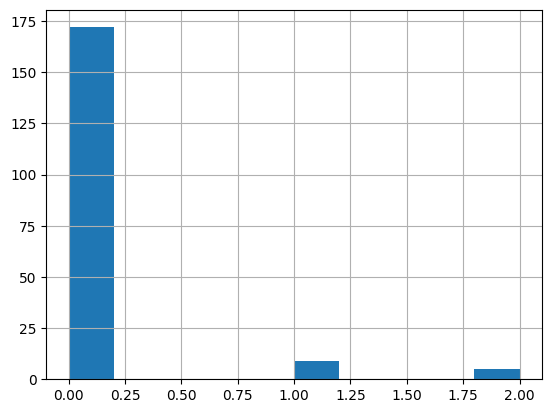

In [ ]:
icici['Target'] = mytarget(icici, 20)
icici['Target'].hist()

In [ ]:
icici.dropna(inplace=True)
print(f'The dataframe now has {icici.shape[0]} rows and {icici.shape[1]} columns')

The dataframe now has 186 rows and 17 columns


In [ ]:
attributes = ['MACDsignal', 'MACDval', 'MACDh', 'RSI', 'OBV', 'TP_BB', 'BOLM', 'BOLU', 'BOLD']

from sklearn.model_selection import train_test_split


X = icici[attributes]
y = icici['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = 0.3)

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('Train Results:')
print(f'Accuracy: {acc_train}')
print('Test Results:')
print(f'Accuracy:{acc_test}')

Train Results:
Accuracy: 1.0
Test Results:
Accuracy:0.9107142857142857


In [ ]:
matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[120   0   0]
 [  0   7   0]
 [  0   0   3]]
[[51  1  0]
 [ 2  0  0]
 [ 2  0  0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00         7
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95        52
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2

    accuracy                           0.91        56
   macro avg       0.31      0.33      0.32        56
weighted avg       0.86      0.91      0.89        56



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


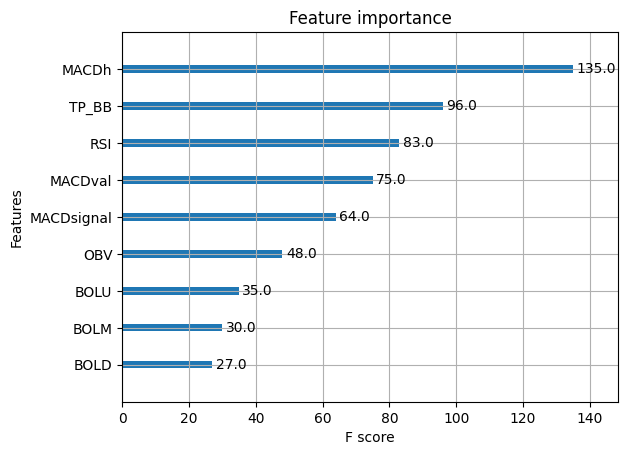

In [ ]:
plot_importance(model)
plt.show()